In [10]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

In [11]:
from keras.datasets import mnist
from sklearn.linear_model import Ridge

Given code
-----------


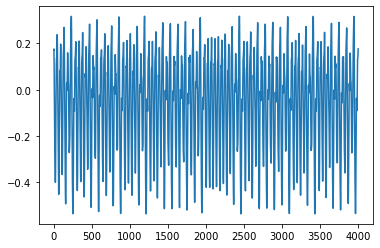

In [12]:

# check for intuition at  http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements
length=4000 # duration of the series
tau=17 # delay in the equation
y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

In [13]:
def plot_outputs(target, output, output_color='magenta', target_color='cyan', error_color='red'):
    plt.subplots(figsize=(20,10))
    plt.plot(target, color=target_color, linewidth=4)
    plt.plot(output, color=output_color, linewidth=1.5)
    error = np.abs(output - target)
    plt.plot(error, color=error_color)
    plt.show()

def plot_weight_matrix(w, shape, figsize=(20,5)):
    w = np.resize(w, shape)
    plt.subplots(figsize=figsize)
    plt.imshow(w, cmap='gray')
    plt.show()

def tanh(x):
    return np.tanh(x).real

2. Take the first 3,000 steps for the training and leave the last 1,000 steps for the testing. 
3. Fix the reservoir size to Nx = 1,000 neurons.
4. Generate input weight matrix Win from uniform distribution between -1 and 1. Scale Win by 0.2.
5. Do not forget to add a bias input neuron, which constantly feeds 1 to the reservoir.
6. Set the spectral radius (feedback strength) for the reservoir connection matrix to ρ = 0.8. 
 

In [14]:
def splitArrayTwo(array, firstLength):
    firstArray = array[:firstLength]
    secoundArray = array[firstLength:]
    firstArray = np.array(firstArray)
    secoundArray = np.array(secoundArray)
    
    return firstArray, secoundArray

train_set , test_set = splitArrayTwo(y, 3000)
print(len(train_set), len(test_set))

3000 1000


In [15]:
res_size = 1000

scale = 0.2
weight_min = -1
weight_max = 1
weight_in = np.random.uniform(weight_min, weight_max, (res_size, 2)) * scale
weight_res = np.random.uniform(weight_min, weight_max, (res_size, res_size)) * scale

bias = 1
p = 0.8

eigen_val = max(np.abs(np.linalg.eigvals(weight_res)))
weight_res = weight_res / eigen_val * p

In [16]:
def training(train_set):
    weight_out = np.random.uniform(weight_min, weight_max, (1, (res_size+1+1))) * scale
    weight_back = np.random.uniform(weight_min, weight_max, (res_size, 1)) * scale

    x = np.zeros(1000)
    y = np.zeros(1)
    reg_X = []
    reg_Y = []

    discard = 1000
    ridge_reg = Ridge()

    for i in range(1, 2998):
        u = np.array([train_set[i], bias])
        y = np.array([train_set[i-1]]).real

        in_dot = np.dot(weight_in, u)
        res_dot = np.dot(weight_res, x)
        back_dot = np.dot(weight_back, y)

        concatenation = np.concatenate([u, x])

        x = tanh(in_dot + res_dot + back_dot)
        y = np.array(np.dot(weight_out, concatenation)) #from functions 4, 15 & 16 in the paper as well as the first sentance on page 15

        y_target = np.array([train_set[i+1]]).real
        reg_X.append(concatenation)
        reg_Y.append(y_target)
    
    ridge_reg.fit(reg_X[discard:], reg_Y[discard:]) # data from the beginning of the training run are discarded since they are contaminated by initial transients.
    weight_out = ridge_reg.coef_

    plot_weight_matrix(weight_out, shape=[5,160])

    return x, y, weight_out, weight_back

In [17]:
def ESN(test_set, x, y, weight_in, weight_back, weight_out, weight_res):
    y_tot = []
    error = []
    for i in range(0, len(test_set)-1):
        u = np.array([test_set[i], bias])

        in_dot = np.dot(weight_in, u)
        res_dot = np.dot(weight_res, x)
        back_dot = np.dot(weight_back, y)

        concatenation = np.concatenate([u, x])

        x = tanh(in_dot + res_dot + back_dot)
        y = np.array(np.dot(weight_out, concatenation)) #from functions 4, 15 & 16 in the paper as well as the first sentance on page 15

        y_target = np.array([test_set[i+1]]).real

        error.append(np.abs(y-y_target))
        y_tot.append(y)
        
    return np.array(error), np.array(y_tot)

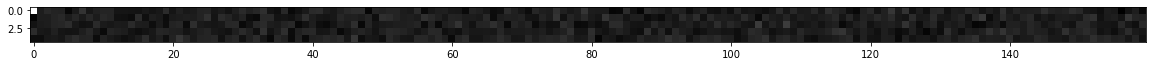

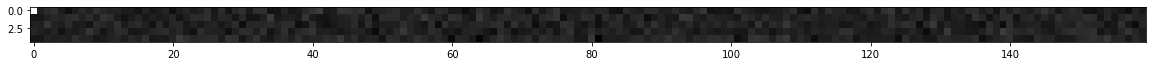

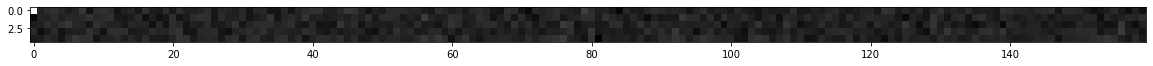

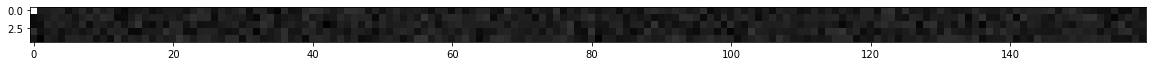

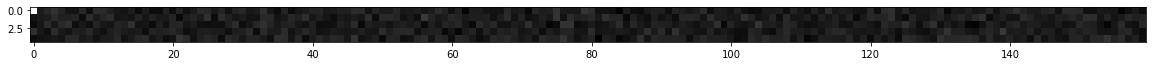

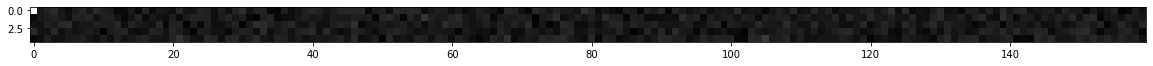

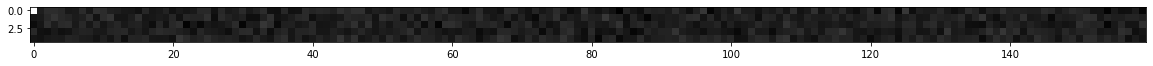

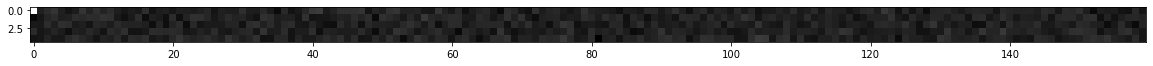

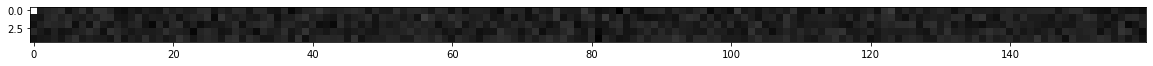

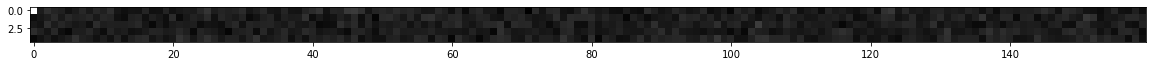

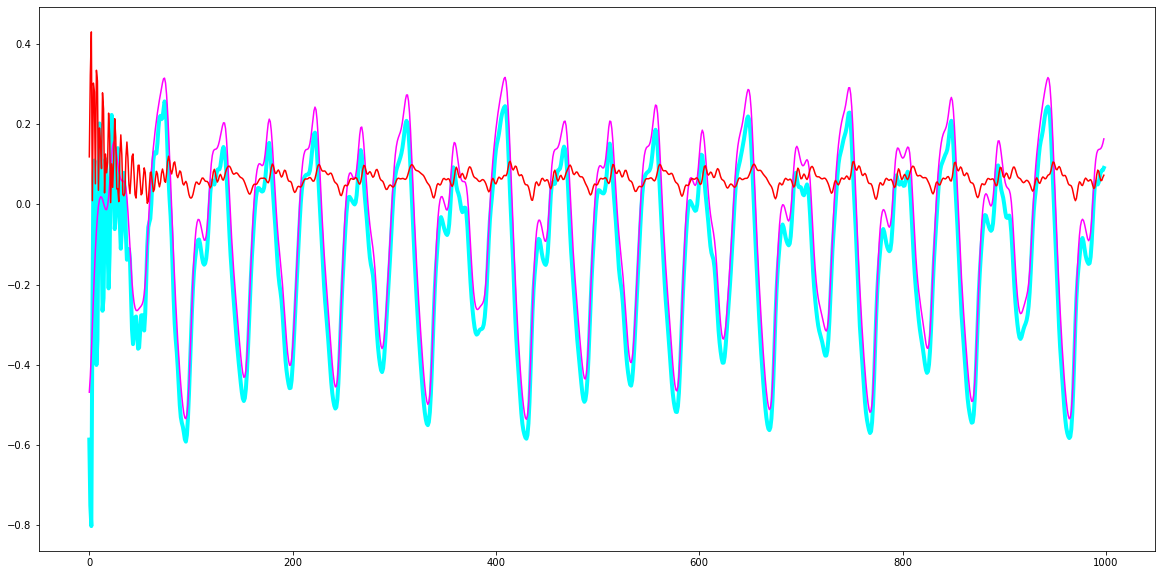

Mean error 0.07013799687603028


In [18]:
y_mean = []
mean_error = []

for i in range(10):
    x, y, weight_out, weight_back = training(train_set)
    error, y_i = ESN(test_set, x, y, weight_in, weight_back, weight_out, weight_res)
    y_mean.append(y_i)
    mean_error.append(error)

y_mean = np.mean(np.array(y_mean), axis=0)
mean_error = np.mean(np.array(mean_error))

plot_outputs(y_mean.flatten(), test_set[:len(test_set)-1])
print('Mean error', mean_error)